In [1]:
import artm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import sys
sys.path.append('..')
sys.path.append('../..')

from library import TopicPriorRegularizer, SemanticHeterogenityRegularizer, custom_fit_offline
from library import ModelStatistics

In [2]:
DATA_PATH = '../data/lenta_1000_100.vw'
BATCH_PATH = '../data/lenta_1000_100_batches'
DICT_PATH = '../data/lenta_1000_100.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

## Topic prior regularizer

In [3]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

custom_regularizers = [
    TopicPriorRegularizer('topic_prior', 2, beta=[0.1, 0.9])
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 10)

In [4]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 10)

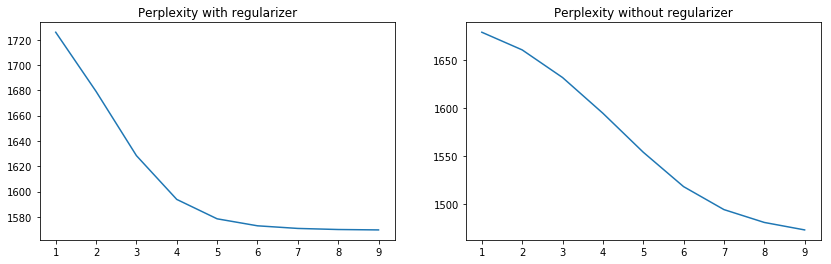

In [5]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

## Semantic heterogenity regularizer

In [6]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

statistics = ModelStatistics(model_lenta)
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 0.05, statistics, batch_vectorizer_lenta)
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 10)

In [ ]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 10)

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)